## Overview
As a high-level overview, other than the historical price of the stock itself, the features
that are generally useful for stock price prediction are as follows:
* ### Correlated assets 
        An organization depends on and interacts with many external factors, including
        its competitors, clients, the global economy, the geopolitical situation, fiscal and
        monetary policies, access to capital, and so on. Hence, its stock price may be cor‐
        related not only with the stock price of other companies but also with other
        assets such as commodities, FX, broad-based indices, or even fixed income
        securities.
* ### Technical indicators
        A lot of investors follow technical indicators. Moving average, exponential mov‐
        ing average, and momentum are the most popular indicators.
* ### Fundamental analysis
        Two primary data sources to glean features that can be used in fundamental
        analysis include:
        * Performance reports
        Annual and quarterly reports of companies can be used to extract or deter‐
        mine key metrics, such as ROE (Return on Equity) and P/E (Price-toEarnings).
        * News
        News can indicate upcoming events that can potentially move the stock price
        in a certain direction.

# 1. Problem definition
In this notebook we will use various supervised learning–based models to predict
the stock price of Microsoft using correlated assets and its own historical data.
Mainly, we will focus on:
* Looking at various machine learning and time series models that can be used to predict stock returns.
* Visualization of the data using different kinds of charts (i.e., density, correlation, scatterplot, etc.)
* Using deep learning (LSTM) models for time series forecasting.
* Implementation of the grid search for time series models (i.e., ARIMA model).
* Interpretation of the results and examining potential overfitting and underfitting of the data across the models.


The dataset used is extracted from Yahoo Finance and the FRED website.We will use the daily closing price of the last 10 years, from 2010 onward.

# 2. Getting started—loading the data and Python packages


## 2.1 Loading Python Packages

In [37]:
# Function and modules for data preparation and visualization
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import matplotlib
from matplotlib import pyplot
import sklearn as sk
import keras
import tensorflow
import statsmodels
import seaborn as sns
import talos

In [38]:
print('## **** Versions *****')
print('numpy==' + np.__version__ , 'pandas==' + pd.__version__ , 'pandas_datareader==' + pdr.__version__ , 
      'matplotlib==' + matplotlib.__version__ , 'sklearn==' +  sk.__version__ , 'keras==' + keras.__version__, 
      'tensorflow==' + tensorflow.__version__ , 'statsmodels==' +  statsmodels.__version__ , 'seaborn==' +  sns.__version__ ,
      'talos==' + talos.__version__ ,
      sep='\n' ) 

## **** Versions *****
numpy==1.22.3
pandas==1.4.3
pandas_datareader==0.10.0
matplotlib==3.5.3
sklearn==1.1.2
keras==2.8.0
tensorflow==2.8.2
statsmodels==0.13.2
seaborn==0.11.2
talos==1.3


In [41]:
# Function and modules for the supervised regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
#
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
#
## Bagging
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
## Boosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
#
from sklearn.neural_network import MLPRegressor

# Function and modules for data analysis and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
#
from sklearn.metrics import mean_squared_error
#
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Function and modules for deep learning models
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

# Function and modules for time series models
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# Function and modules for data preparation and visualization
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

## 2.2 Loading Data

loading data from the Yahoo Finance and FRED websites using the Pandas DataReader


In [43]:
## Add required Tickers to the data dictionary 
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

## Get the data passing above ticker list to Pandas data Reader
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

Next, we define our dependent (Y) and independent (X) variables. 

The predicted variable is the weekly return of Microsoft (MSFT). 
The number of trading days in a week is assumed to be five, and we compute the return using five trading days. 

For independent variables we use the correlated assets and the historical return of MSFT at different frequencies.
The variables used as independent variables are 
* lagged 5-day return of stocks (IBM and GOOG), 
* lagged 5-day return of currencies (USD/JPY and GBP/USD), and 
* lagged 5-day return of indices (S&P 500, DowJones, and VIX), 
* lagged 5-day, 15-day, 30-day and 60-day return of MSFT.

The lagged five-day variables embed the time series component by using a time-delay approach, where the lagged variable is included as one of the independent variables.
This step is reframing the time series data into a supervised regression–based model framework.


In [52]:
return_period = 5
X2 = np.log(ccy_data).diff(return_period)
print(X2.columns)


Index(['DEXJPUS', 'DEXUSUK'], dtype='object')


In [53]:
return_period = 5
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)

Y.name = Y.name[-1]+'_pred'

# lagged 5-day return of stocks (IBM and GOOG)
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()

# lagged 5-day return of currencies (USD/JPY and GBP/USD)
X2 = np.log(ccy_data).diff(return_period)

# lagged 5-day return of indices (S&P 500, DowJones, and VIX)
X3 = np.log(idx_data).diff(return_period)

# lagged 5-day, 15-day, 30-day and 60-day return of MSFT.
X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) 
for i in [return_period, return_period*3,return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']


# Concatenation of all the features and target variables into a dataset
X = pd.concat([X1, X2, X3, X4], axis=1)
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]

Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

# 3. Exploratory data analysis
We will look at descriptive statistics, data visualization, and time series analysis in
this section.
## 3.1. Descriptive statistics. Let’s have a look at the dataset we have:


In [49]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-11-22,0.012673,0.014854,0.031254,-0.013614,0.009525,0.012577,0.010894,-0.284387,0.001565,0.004167,0.088930,0.134030
2017-12-01,-0.001187,-0.030220,0.019048,0.003044,0.012593,0.015178,0.028192,0.167213,0.011939,0.007029,0.083363,0.130267
2017-12-08,0.031463,0.023439,0.000323,0.014816,-0.010271,0.003506,0.004018,-0.176564,-0.001187,0.011473,0.071324,0.123313
2017-12-15,-0.015549,0.021326,-0.015034,-0.007691,-0.003823,0.009127,0.013172,-0.016843,0.031463,0.042214,0.037780,0.162293
2017-12-22,0.005132,-0.002933,0.000000,0.005487,0.004720,0.002810,0.004142,0.049700,-0.015549,0.014726,0.021755,0.151336


In [56]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2017-11-22 to 2022-08-16
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MSFT_pred  225 non-null    float64
 1   GOOGL      225 non-null    float64
 2   IBM        225 non-null    float64
 3   DEXJPUS    225 non-null    float64
 4   DEXUSUK    225 non-null    float64
 5   SP500      225 non-null    float64
 6   DJIA       225 non-null    float64
 7   VIXCLS     225 non-null    float64
 8   MSFT_DT    225 non-null    float64
 9   MSFT_3DT   225 non-null    float64
 10  MSFT_6DT   225 non-null    float64
 11  MSFT_12DT  225 non-null    float64
dtypes: float64(12)
memory usage: 22.9 KB


In [58]:
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,0.004932,0.002952,0.001802,0.000866,-0.000394,0.002361,0.001872,0.000909,0.005268,0.015855,0.030803,0.066890
std,0.035297,0.038123,0.040119,0.011084,0.013804,0.028707,0.029715,0.166149,0.033778,0.059121,0.070182,0.093578
min,-0.137317,-0.131259,-0.173146,-0.052258,-0.066158,-0.140676,-0.166713,-0.401002,-0.137317,-0.239569,-0.299102,-0.180214
25%,-0.015566,-0.020716,-0.014824,-0.005191,-0.007614,-0.010028,-0.011250,-0.108302,-0.013520,-0.014448,-0.004215,0.014550
50%,0.007575,0.006894,0.004583,0.000756,-0.000831,0.005714,0.004142,-0.018876,0.008803,0.021046,0.039438,0.087884
75%,0.026374,0.025061,0.023492,0.006562,0.006834,0.016402,0.017035,0.080940,0.025631,0.048122,0.076708,0.130267
max,0.164102,0.096339,0.175315,0.052731,0.075400,0.160395,0.183091,0.650554,0.164102,0.244822,0.207462,0.293344


## 3.2. Data Visualization:
We will look at the scatterplot and the correlation matrix. These plots give us a sense
of the interdependence of the data

<AxesSubplot:title={'center':'Correlation Matrix'}>

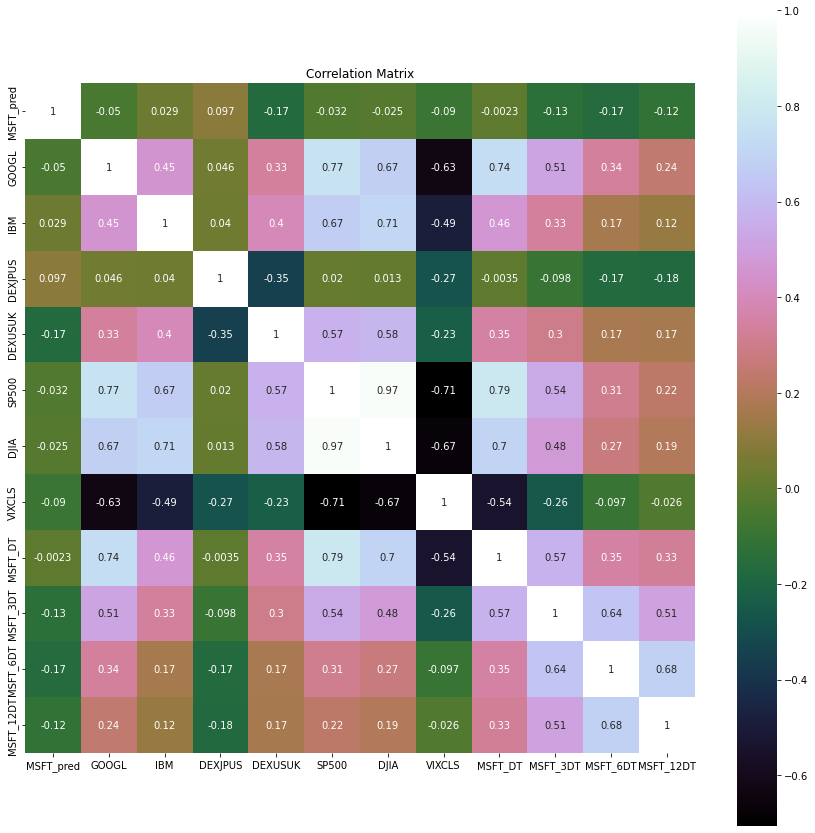

In [54]:
# Correlation Matrix
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')


Looking at the correlation plot, 
* We see some correlation of the predicted variable with the lagged 5-day, 15-day, 30-day, and 60-day returns of MSFT. 
* Also, we see a higher negative correlation of many asset returns versus VIX, which is intuitive.

<Figure size 1080x1080 with 0 Axes>

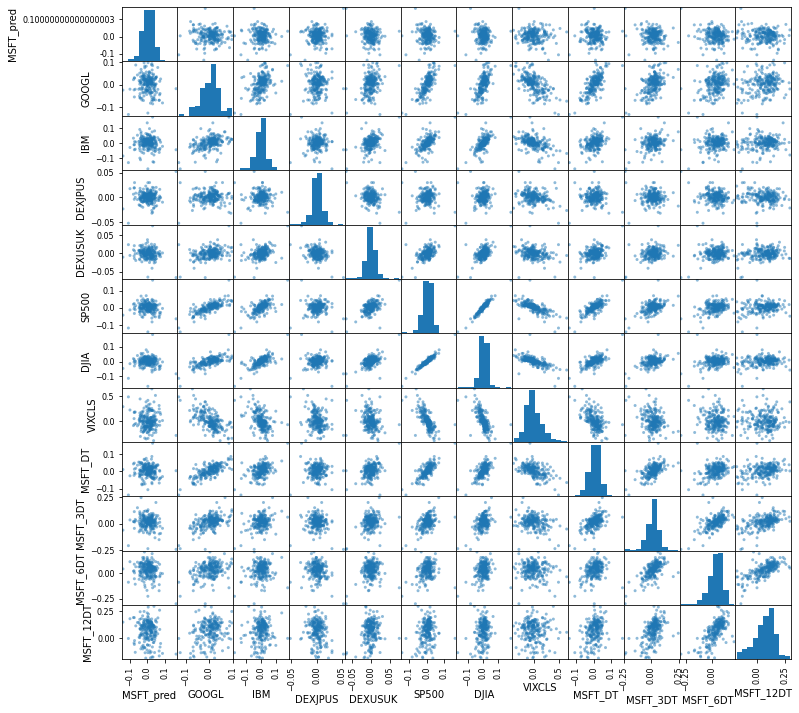

In [55]:
# Scatterplot Matrix
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()


Looking at the scatterplot, 
* We see some linear relationship of the predicted variable with the lagged 15-day, 30-day, and 60-day returns of MSFT. 
* Otherwise, we do not see any special relationship between our pre‐dicted variable and the features.


# 3.3. Time series analysis

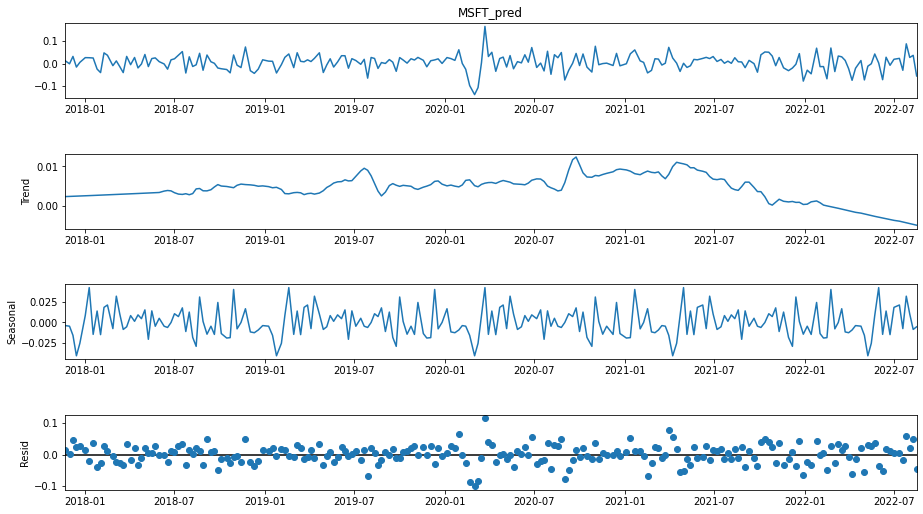

In [63]:
# Decompose time series of the predicted variable into trend and seasonality components:
from statsmodels.tsa.seasonal import seasonal_decompose 
res = seasonal_decompose(Y, period=52, extrapolate_trend='freq')
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

## 4. Data preparation
This step typically involves data processing, data cleaning, looking at feature impor‐tance, and performing feature reduction. 
Feature reduction might be useful here, but given the relatively small number of variables considered, we will keep all of them as is. 


## 5. Evaluate models

### 5.1. Train-test split and evaluation metrics

We will use 80% of the dataset for modeling and use 20% for testing. 
With time series data, the sequence of values is important. 
So we do not distribute the dataset into training and test sets in random fashion, but we select an arbitrary split point in the ordered list of observations and create two new datasets:

In [64]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]


### 5.2. Test options and evaluation metrics.

To optimize the various hyperparameters of the models, we use ten-fold cross validation (CV) and recalculate the results ten times
to account for the inherent randomness in some of the models and the CV process.
We will evaluate algorithms using the mean squared error metric. 
This metric gives an idea of the performance of the supervised regression models.

In [65]:
num_folds = 10
scoring = 'neg_mean_squared_error'

### 5.3. Compare models and algorithms.

#### 5.3.1. Machine learning models from Scikit-learn.

In [66]:
# Create a list of Machine learning models to evaluate

# Regression and tree regression algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
# Neural network algorithms
models.append(('MLP', MLPRegressor()))
# Ensemble models
## Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
## Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

We run the model on the entire training and testing dataset.
All the algorithms use default tuning parameters.
We will calculate the mean and standard deviation of the evaluation metric for each algorithm and collect the results for model comparison

In [69]:
names = []
kfold_results = []
test_results = []
train_results = []
seed = 42

for name, model in models:
    names.append(name)

    ## k-fold analysis:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    #converted mean squared error to positive. The lower the better
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

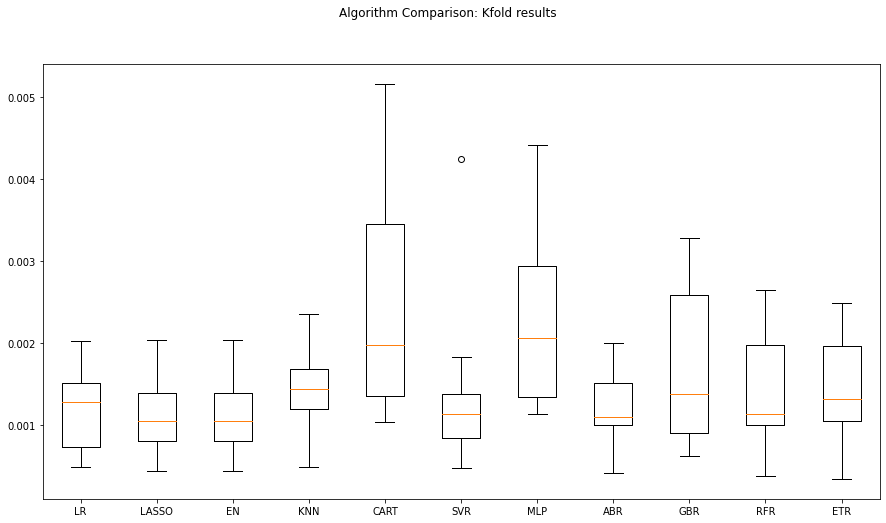

In [70]:
# Let’s compare the algorithms by looking at the cross validation results:
# Cross validation results
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()


Although the results of a couple of the models look good, we see that the linear
regression and the regularized regression including the lasso regression (LASSO) and
elastic net (EN) seem to perform best. This indicates a strong linear relationship
between the dependent and independent variables. Going back to the exploratory
analysis, we saw a good correlation and linear relationship of the target variables with
the different lagged MSFT variables.
Let us look at the errors of the test set as well:


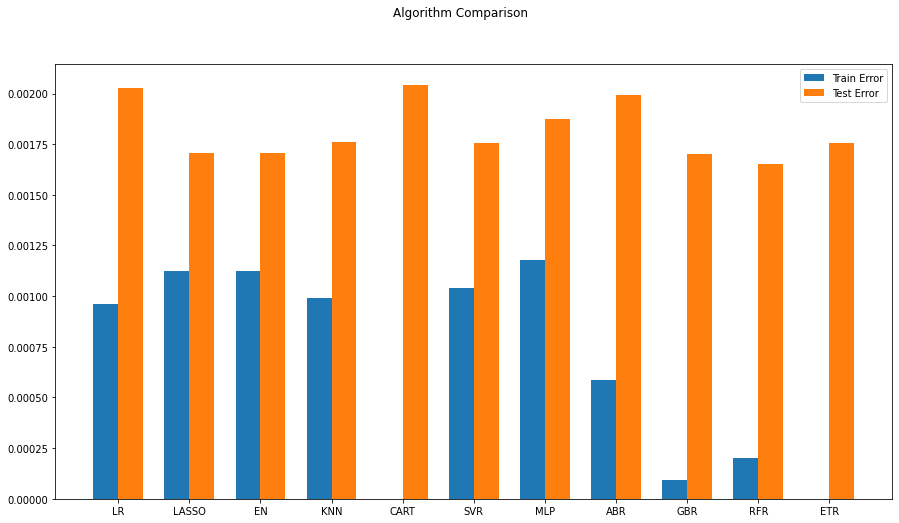

In [71]:
# Training and test error
# compare algorithms
fig = pyplot.figure()
ind = np.arange(len(names)) # the x locations for the groups
width = 0.35 # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results, width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Examining the training and test error, we still see a stronger performance from the linear models. 
Some of the algorithms, such as the decision tree regressor (CART), overfit on the training data and produced very high error on the test set. 
Ensemble models such as gradient boosting regression (GBR) and random forest regression (RFR) have low bias but high variance. 
We also see that the artificial neural network algorithm (shown as MLP in the chart) shows higher errors in both the training and test sets. 
This is perhaps due to the linear relationship of the variables not captured accurately by ANN, improper hyperparameters, or insufficient training of the model.

Our original intuition from the cross validation results and the scatterplots also seem to demonstrate a better performance of linear models.

We now look at some of the time series and deep learning models that can be used.
Once we are done creating these, we will compare their performance against that of the supervised regression–based models. Due to the nature of time series models, we
are not able to run a k-fold analysis. We can still compare our results to the other models based on the full training and testing results.

#### 5.3.2. Time series–based models: ARIMA and LSTM

The models used so far already embed the time series component by using a time-delay approach, where the lagged variable is included as one of the independent variables.
However, for the time series–based models we do not need the lagged variables of MSFT as the independent variables. 

Hence, as a first step we remove MSFT’s previous returns for these models.
We use all other variables as the exogenous variables in these models. 
Let us first prepare the dataset for ARIMA models by having only the correlated variables as exogenous variables

In [72]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

We now configure the ARIMA model with the order (1,0,0) and use the independent variables as the exogenous variables in the model. 

The version of the ARIMA model where the exogenous variables are also used is known as the ARIMAX model, where
"X" represents exogenous variables:

In [78]:
import statsmodels.api as sma

modelARIMA= sma.tsa.SARIMAX(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

# Now we fit the ARIMA model:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

/home/ubuntu22/anaconda3/envs/sriMLModels/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ubuntu22/anaconda3/envs/sriMLModels/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ubuntu22/anaconda3/envs/sriMLModels/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu22/anaconda3/envs/sriMLModels/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given

0.0017827740080413295

Error of this ARIMA model is reasonable.

Now let’s prepare the dataset for the LSTM model. We need the data in the form of arrays of all the input variables and the output variables.
The logic behind the LSTM is that data is taken from the previous day (the data of all the other features for that day—correlated assets and the lagged variables of MSFT)
and we try to predict the next day. Then we move the one-day window with one day and again predict the next day. We iterate like this over the whole dataset (of course
in batches). 

The code below will create a dataset in which X is the set of independent variables at a given time (t) and Y is the target variable at the next time (t + 1):

In [79]:
seq_len = 2 #Length of the seq for the LSTM
Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
 X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
 X_test_LSTM[:, i, :] = np.array(X)\
 [X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [80]:
# LSTM Network
def create_LSTMmodel(learn_rate = 0.01, momentum=0):
 # create model
 model = Sequential()
 model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
 #More cells can be added if needed
 model.add(Dense(1))
 optimizer = SGD(lr=learn_rate, momentum=momentum)
 model.compile(loss='mse', optimizer='adam')
 return model

LSTMModel = create_LSTMmodel(learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM), epochs=330, batch_size=72, verbose=0, shuffle=False)

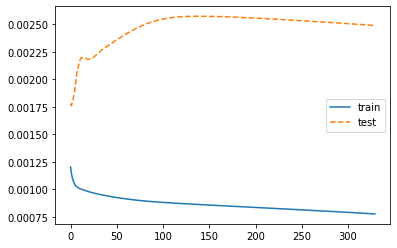

In [81]:
# Now we fit the LSTM model with the data and look at the change in the model performance metric over time simultaneously in the training set and the test set:
pyplot.plot(LSTMModel_fit.history['loss'], label='train', )
pyplot.plot(LSTMModel_fit.history['val_loss'], '--',label='test',)
pyplot.legend()
pyplot.show()

In [82]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

In [83]:
# Now, in order to compare the time series and the deep learning models, we append the result of these models to the results of the supervised regression–based models

test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)
train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)
names.append("ARIMA")
names.append("LSTM")

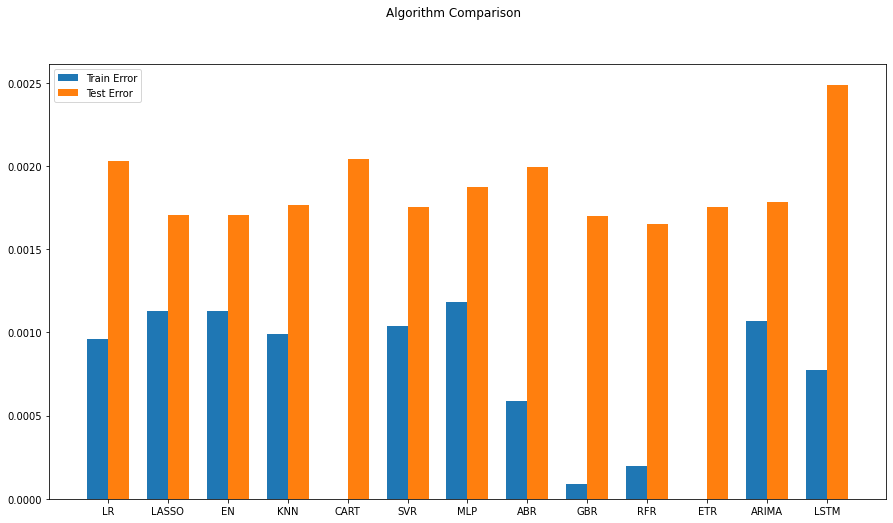

In [84]:
# Training and test error
# compare algorithms
fig = pyplot.figure()
ind = np.arange(len(names)) # the x locations for the groups
width = 0.35 # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results, width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Looking at the chart, we find the time series–based ARIMA model comparable to the linear supervised regression models: 
* linear regression (LR), 
* lasso regression (LASSO), and 
* elastic net (EN). 
This can primarily be due to the strong linear relationship as discussed before. 

The LSTM model performs decently; however, the ARIMA model outperforms the LSTM model in the test set. 
Hence, we select the ARIMA model for model tuning.

# 6. Model tuning and grid search

The ARIMA model is generally represented as ARIMA(p,d,q) model, where 
* p is the order of the autoregressive part, 
* d is the degree of first differencing involved, and 
* q is the order of the moving average part. 

The order of the ARIMA model was set to (1,0,0). 
So we perform a grid search with different p, d, and q combinations in the ARIMA model’s order and select the combination that minimizes the fitting error:


In [99]:
import warnings

def evaluate_arima_model(arima_order):
    #predicted = list()
    #modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    modelARIMA=sma.tsa.SARIMAX(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=0.0010862
ARIMA(0, 0, 1) MSE=0.0010733
ARIMA(1, 0, 0) MSE=0.0010673
ARIMA(1, 1, 1) MSE=0.0010579
ARIMA(2, 1, 1) MSE=0.0010547
Best ARIMA(2, 1, 1) MSE=0.0010547


We see that the ARIMA model with the order (2,1,1) is the best performer out of all
the combinations tested in the grid search, although there isn’t a significant differ‐
ence in the mean squared error (MSE) with other combinations. This means that the
model with the autoregressive lag of two and moving average of one yields the best
result. We should not forget the fact that there are other exogenous variables in the
model that influence the order of the best ARIMA model as well.

# 7. Finalize the model
In the last step we will check the finalized model on the test set.

## 7.1. Results on the test dataset.

In [100]:
# prepare model
modelARIMA_tuned=sma.tsa.SARIMAX(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 , end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))


0.0017827740080413295


The MSE of the model on the test set looks good and is actually less than that of the training set.
In the last step, we will visualize the output of the selected model and compare the modeled data against the actual data. 

In order to visualize the chart, we convert the return time series to a price time series. 
We also assume the price at the beginning of the test set as one for the sake of simplicity. 
Let us look at the plot of actual versus predicted data:


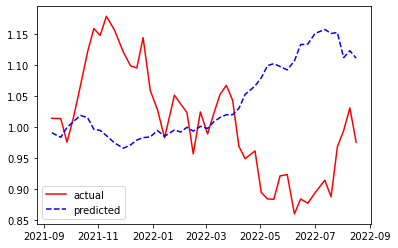

In [101]:
# plotting the actual data versus predicted data
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r', label='actual',)
# plotting t, a separately
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b--', label='predicted')
pyplot.legend()
pyplot.rcParams["figure.figsize"] = (8,5)
pyplot.show()


Looking at the chart, we clearly see the trend has been captured perfectly by the model. 

The predicted series is less volatile compared to the actual time series, and it aligns with the actual data for the first few months of the test set. 
A point to note is that the purpose of the model is to compute the next day’s return given the data observed up to the present day, and not to predict the stock price several days in the
future given the current data. 

Hence, a deviation from the actual data is expected as we move away from the beginning of the test set. The model seems to perform well for the first few months, with deviation from the actual data increasing six to seven months after the beginning of the test set.

# Conclusion
We can conclude that simple models: 
* linear regression, 
* regularized regression (i.e.,Lasso and elastic net) along with the 
* time series models, such as ARIMA, are promising modeling approaches for stock price prediction problems. 

This approach helps us deal with overfitting and underfitting, which are some of the key challenges in predicting problems in finance.

We should also note that we can use a wider set of indicators, such as 
* P/E ratio, 
* trading volume, 
* technical indicators, or 
* news data, which might lead to better results. 

